In [21]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("../../Hi-C-embedding/GraphEmbedding")
sys.path.append("../../utilities/")
import data_utils
from ge.models import deepwalk, line, sdne
import networkx as nx
from sklearn.manifold import TSNE

In [8]:
SC_annot = data_utils.read_annot_file('../../data/annotations/GSE63525_GM12878_subcompartments.bed', 0, 100000)
SC_annot = data_utils.melt_annotation(SC_annot)

In [4]:
contact_list = data_utils.create_contact_list("../../data", 'GM12878', 'chr21', 'chr21', 100000)
contact_lists = {}
contact_lists['uni'] = data_utils.uni_dir(contact_list)
contact_lists['bi'] = data_utils.bi_dir(contact_list)
contact_lists['full'] = data_utils.loop_bi_dir(contact_list)

In [5]:
line_embeddings = {}
for d in ['uni','bi']:
    for o in ['first','second']:
        G = nx.from_pandas_edgelist(contact_lists[d], 'id1', 'id2', edge_attr = 'weight', create_using=nx.DiGraph())
        line_embeddings[d,o] = []
        for epoch_num in np.arange(1,16):
            model = line.LINE(G,embedding_size=128,order=o) #init model,order can be ['first','second','all']
            model.train(batch_size=1024,epochs=epoch_num,verbose=2)# train model
            line_embeddings[d,o].append(model.get_embeddings())

Epoch 1/1
1s - loss: 14.7589
Epoch 1/2
1s - loss: 15.2140
Epoch 2/2
1s - loss: 3.4689
Epoch 1/3
1s - loss: 15.0643
Epoch 2/3
1s - loss: 3.4152
Epoch 3/3
1s - loss: 1.1391
Epoch 1/4
1s - loss: 14.8802
Epoch 2/4
1s - loss: 3.3656
Epoch 3/4
1s - loss: 1.1349
Epoch 4/4
1s - loss: 0.8494
Epoch 1/5
1s - loss: 15.2141
Epoch 2/5
1s - loss: 3.4714
Epoch 3/5
1s - loss: 1.1485
Epoch 4/5
1s - loss: 0.8488
Epoch 5/5
1s - loss: 0.7841
Epoch 1/6
1s - loss: 15.2523
Epoch 2/6
1s - loss: 3.4862
Epoch 3/6
1s - loss: 1.1522
Epoch 4/6
1s - loss: 0.8508
Epoch 5/6
1s - loss: 0.7861
Epoch 6/6
1s - loss: 0.7625
Epoch 1/7
1s - loss: 15.1934
Epoch 2/7
1s - loss: 3.4633
Epoch 3/7
1s - loss: 1.1462
Epoch 4/7
1s - loss: 0.8482
Epoch 5/7
1s - loss: 0.7837
Epoch 6/7
1s - loss: 0.7622
Epoch 7/7
1s - loss: 0.7489
Epoch 1/8
1s - loss: 15.2142
Epoch 2/8
1s - loss: 3.4741
Epoch 3/8
1s - loss: 1.1475
Epoch 4/8
1s - loss: 0.8503
Epoch 5/8
1s - loss: 0.7852
Epoch 6/8
1s - loss: 0.7632
Epoch 7/8
1s - loss: 0.7489
Epoch 8/8
1s

Epoch 1/10
3s - loss: 9.3664
Epoch 2/10
3s - loss: 1.0183
Epoch 3/10
3s - loss: 0.7810
Epoch 4/10
3s - loss: 0.7490
Epoch 5/10
3s - loss: 0.7312
Epoch 6/10
3s - loss: 0.7198
Epoch 7/10
3s - loss: 0.7125
Epoch 8/10
4s - loss: 0.7064
Epoch 9/10
4s - loss: 0.7030
Epoch 10/10
4s - loss: 0.7004
Epoch 1/11
6s - loss: 9.2099
Epoch 2/11
3s - loss: 1.0085
Epoch 3/11
3s - loss: 0.7797
Epoch 4/11
3s - loss: 0.7474
Epoch 5/11
3s - loss: 0.7318
Epoch 6/11
3s - loss: 0.7195
Epoch 7/11
3s - loss: 0.7124
Epoch 8/11
3s - loss: 0.7070
Epoch 9/11
3s - loss: 0.7028
Epoch 10/11
3s - loss: 0.7005
Epoch 11/11
3s - loss: 0.6985
Epoch 1/12
3s - loss: 9.4070
Epoch 2/12
3s - loss: 1.0202
Epoch 3/12
3s - loss: 0.7809
Epoch 4/12
3s - loss: 0.7491
Epoch 5/12
3s - loss: 0.7316
Epoch 6/12
3s - loss: 0.7202
Epoch 7/12
3s - loss: 0.7117
Epoch 8/12
3s - loss: 0.7066
Epoch 9/12
3s - loss: 0.7030
Epoch 10/12
3s - loss: 0.7001
Epoch 11/12
3s - loss: 0.6987
Epoch 12/12
3s - loss: 0.6975
Epoch 1/13
3s - loss: 9.2047
Epoch 2/

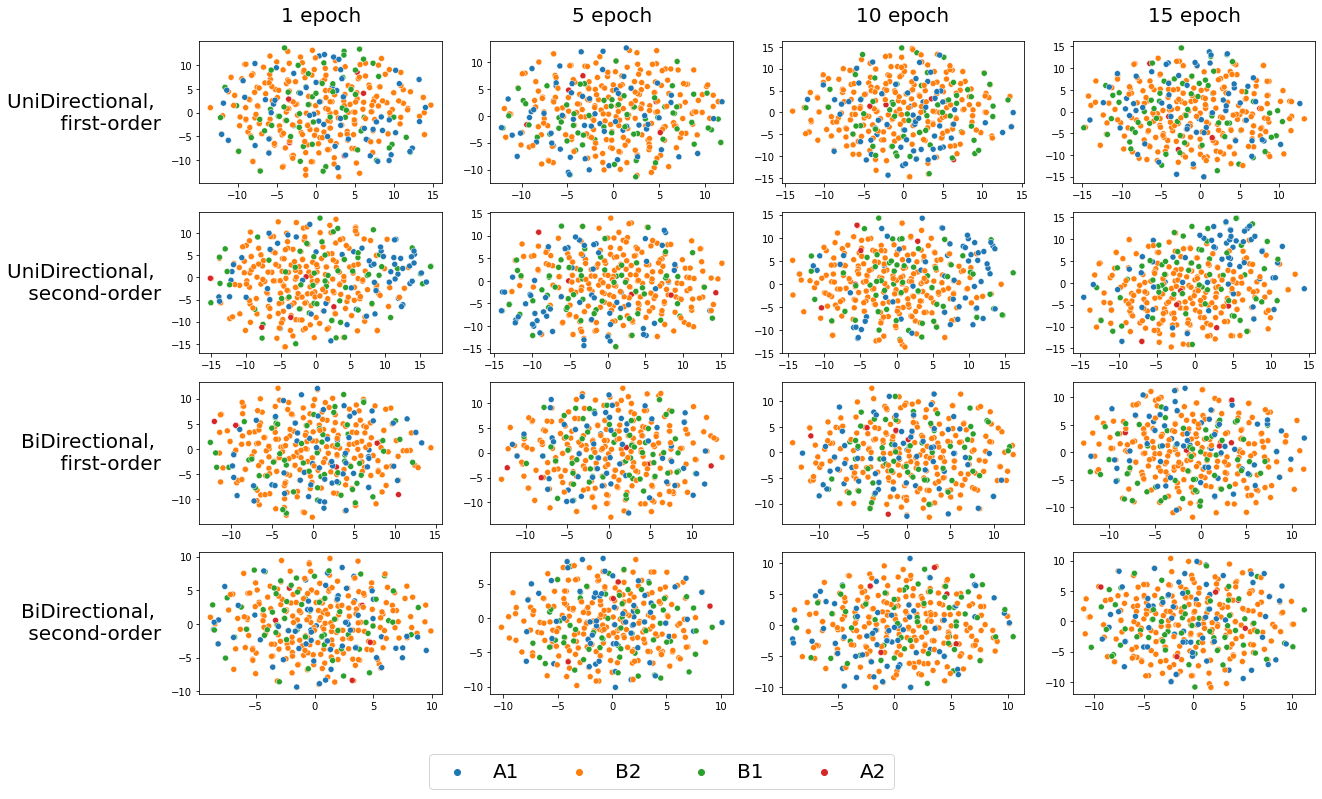

In [24]:
fig, axs = plt.subplots(4, 4, figsize=(20,12))
cnt = 0
for d in ['uni','bi']:
    for o in ['first','second']: 
        for e,epoch in enumerate([1,5,10,15]):
            l = line_embeddings[d,o][0]
            l = data_utils.make_embedding_df(l,"../../data",'GM12878',100000)
            tsne_comps = TSNE(n_components=2,init='random').fit_transform(l.iloc[:,2:])
            l['tsne1'] = tsne_comps[:,0]
            l['tsne2'] = tsne_comps[:,1]
            l = pd.merge(l, SC_annot, on = ['pos','chr_name'], how = 'inner')
            sns.scatterplot(data=l, x = 'tsne1', y = 'tsne2', hue = 'label', ax = axs[cnt,e])
            axs[cnt,e].get_legend().remove()
            axs[cnt,e].set(xlabel = None, ylabel = None)
        cnt = cnt + 1
        
pad = 2 # in points

for ax, col in zip(axs[0], [str(e) + " epoch" for e in [1,5,10,15]]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 10*pad),
                xycoords='axes fraction', textcoords='offset pixels',
                size=20, ha='center', va='baseline')

for ax, row in zip(axs[:,0], ['UniDirectional, \n first-order', 'UniDirectional, \n second-order', 
                           'BiDirectional, \n first-order', 'BiDirectional, \n second-order']):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset pixels',
                size=20, ha='right', va='center')
    
handles, labels = axs[0,0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='right', prop={'size': 30})
fig.legend(handles, labels, loc="lower center", ncol=4, prop={'size': 20})
#fig.tight_layout(pad=1.0)
fig.savefig(os.path.join('figures', "line_data_epochs.png"), 
            format="png", dpi=144, bbox_inches="tight", pad_inches=0.2, facecolor='white', transparent=False)